In [1]:
import yfinance as yf 
import pandas as pd
import numpy as np
from datetime import datetime

import quandl

import sys
import urllib
import os
from matplotlib import pylab as plt 

import quandl

import seaborn as sns

import sys

from scipy.stats import norm

In [2]:
def import_MSCI(name):
    '''Function to clean data from MSCI
    https://www.msci.com/end-of-day-data-country
    '''
    
    
    path = "../Data/" + name + ".xls"
    imp_tmp = pd.read_excel(path)
    price_type = imp_tmp.loc[1][1]
    
    imp = imp_tmp[6:]
    imp.columns = ['Date', name]
    #imp['Date'] = pd.to_datetime(imp['Date'], errors='coerce')
    imp.loc[0] = pd.to_datetime(imp['Date'], errors='coerce')
    imp = imp.dropna()
    
    imp = imp.set_index('Date')
    imp.index = imp.index.strftime('%Y/%m')
    imp.index = pd.to_datetime(imp.index, errors='coerce')
    
    print(price_type)
    
    return(imp)

#def merge_data():
    

In [3]:
def port_eval(port, freq = 'D'):
    
    port = pd.DataFrame(port)
    port_ret = calc_port_ret(port)
    
    Roll_Max = port.cummax()
    Daily_Drawdown = port/Roll_Max - 1.0
    Max_Daily_Drawdown = Daily_Drawdown.cummin()
    
    Max_Daily_Drawdown = round(Max_Daily_Drawdown.tail(1),2)
    
    neg_ret = port_ret[port_ret<1].dropna()
    
    mean = np.mean(port_ret - 1)
    std = np.std(port_ret - 1)
    
    alpha = 0.05
    ES = round(alpha**-1 * norm.pdf(norm.ppf(alpha))*std - mean,3)
 
    
    if freq == 'D':
        cagr = round(port_ret.cumprod().tail(1)**(252/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,2)
        vol = round(np.log(port_ret).std()*np.sqrt(252),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(252),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)
        
    elif freq == 'M':
        cagr = round(port_ret.cumprod().tail(1)**(12/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,2)
        vol = round(np.log(port_ret).std()*np.sqrt(12),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(12),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)
        
        
    metrics = pd.DataFrame({'': [float(cagr.iloc[0]), float(vol.iloc[0]),
                                 float(sharpe.iloc[0]),float(sortino.iloc[0]),
                                 float(Max_Daily_Drawdown.iloc[0]), abs(float(MAR.iloc[0]))]},
                   index=['CAGR', 'Volatility', 'Sharpe','Sortino', 'Max DD', 'MAR'])
    
    return metrics 

In [4]:
def strategy_evaluation(result, data_names, freq = 'D'):
    metrics = pd.DataFrame([])
    
    if freq == 'D':
    
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'D').transpose()], axis = 0)
        metrics.index = ["Portfolio"] + data_names
        
    elif freq == 'M':
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'M').transpose()], axis = 0)
        metrics.index = ["Portfolio"] + data_names
        
    th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'Black'),
  ('background-color', '#f7f7f9')
  ]


    # Set CSS properties for td elements in dataframe
    td_props = [
      ('font-size', '11px'), ('text-align', 'center')
      ]

    # Set table styles
    styles = [
      dict(selector="th", props=th_props),
      dict(selector="td", props=td_props)
      ]

    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=len(metrics.columns), as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=len(metrics.columns), as_cmap=True)

    metrics = (metrics.style
      .background_gradient(axis = 0 ,subset = ['CAGR','Max DD', 'Sharpe','MAR','Sortino' ],cmap=cm_pos_good)
      .background_gradient(axis = 0 ,subset = ['Volatility'],cmap=cm_neg_good)
      #.set_caption('Performance Metrics')
      .format({'CAGR': "{:.2%}", 'Max DD': "{:.2%}", 'Volatility': "{:.2%}"})
      .set_table_styles(styles))
    
    return metrics

In [5]:
def calc_port_ret(port):
    port_ret = port/port.shift(1)
    port_ret = port_ret.fillna(1)
    
    return port_ret

In [6]:
def calc_bond_returns(YTM, YTMM1, M):
    DY = YTM - YTMM1
    yield_income = (1+YTM)**(1/12) - 1
    Z = (1+(YTM/2))
    

    duration = (1/YTM)* (1 -(1/(1+0.5*YTM)**(2*M)))


    C1 = (2/YTM**2) * (1-Z**(-2*M))
    C2 = ((2*M)/YTM) * Z **(-2*M - 1) 
    convex = C1-C2

    ret = yield_income - duration* DY + (1/2)*convex * (DY**2)
    return(ret)

def monthly_bonds_ret(bond_YTM, M):
    bond_ret = [0]

   
    
    for i in range(len(bond_YTM)-1):
        YTM = bond_YTM[i+1]
        YTMM1 = bond_YTM[i]
        
        ret = calc_bond_returns(YTM, YTMM1, M)
        bond_ret.append(ret)

    bond_ret = pd.DataFrame(bond_ret)
    bond_ret.index = bond_YTM.index + pd.Timedelta('1 day')
    
    bond_ret = (bond_ret+1).cumprod()
    return(bond_ret)

# Trend Followning Backtest

In [7]:
Gold_tmp = quandl.get("LBMA/GOLD", authtoken="6rNSyTM5R4g7_B7XSyQW")
Gold = pd.DataFrame(Gold_tmp["USD (AM)"])
Gold = Gold.resample('M').last()
Gold.index = Gold.index.strftime('%Y/%m')
Gold.index = pd.to_datetime(Gold.index, errors='coerce')

In [ ]:
bond_5YR_tmp = yf.download('^FVX') #data import
bond_5YR = bond_5YR_tmp['Adj Close']
bond_5YR_monthly = bond_5YR.resample('M').last()/100

bond_5YR = monthly_bonds_ret(bond_5YR_monthly, 5)
bond_5YR.columns = ['Bond 5 Yr']

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/anaconda3/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.7/site-packages/multitasking/__init__.py", line 102, in _run_via_pool
    return callee(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.7/site-packages/yfinance/multi.py", line 167, in _download_one_threaded
    actions, period, interval, prepost, proxy, rounding)
  File "/opt/anaconda3/lib/python3.7/site-packages/yfinance/multi.py", line 182, in _download_one
    rounding=rounding, many=True)
  File "/opt/anaconda3/lib/python3.7/site-packages/yfinance/base.py", line 155, in history
    data = data.json()
  File "/opt/anaconda3/lib/python3.7/site-packages/requests/models.py", line 897, in json
    return complexjson.loads(self.text, **kwargs)
  File "/opt/anaconda3/lib/python

In [ ]:
USA = import_MSCI('USA')
RUSSIA = import_MSCI('RUSSIA')
SWEDEN = import_MSCI('SWEDEN')
Emerging_Markets = import_MSCI('Emerging_Markets')
JAPAN = import_MSCI('JAPAN')
PACIFIC_ex_JAPAN = import_MSCI('PACIFIC_ex_JAPAN')
small_cap = import_MSCI('SWEDISH_SMALL')

In [ ]:
data = pd.concat([USA,SWEDEN, JAPAN, PACIFIC_ex_JAPAN, Gold, bond_5YR], axis = 1)
data = data.dropna()


### Data Wrangling

In [ ]:
top_n_assets =3


mom_df = data.copy()
mom3_df=mom_df.apply(lambda x:x/x.shift(3) - 1, axis=0)
mom6_df=mom_df.apply(lambda x:x/x.shift(6) - 1, axis=0)
mom12_df=mom_df.apply(lambda x:x/x.shift(12) - 1, axis=0)

comb_mom_df=mom12_df+mom6_df+mom3_df



In [ ]:
returns_df=data.copy()
returns_df=returns_df.apply(lambda x:x.shift(-1)/x - 1, axis=0)
returns_df=returns_df.iloc[12:]

### Backtest

In [ ]:
rank_df=comb_mom_df.iloc[12:].rank(axis=1,ascending=False)

In [ ]:
for col in rank_df.columns:
    rank_df[col]=np.where(rank_df[col]<=top_n_assets, 1, 0)

In [ ]:
portf=np.multiply(rank_df,returns_df)
portf_rets=portf.sum(axis =1)/top_n_assets

portf_rets = portf_rets
portf_rets = pd.DataFrame(portf_rets)
portf_rets.columns = ['TF']

In [ ]:
bench_ret = USA.shift(-1)/USA - 1

result = pd.concat([portf_rets, bench_ret],axis = 1, sort=False)
result = result.dropna()



result_cum = result+1
result_cum = result_cum.cumprod()
result_cum = result_cum.astype('float64')

#result

### Result

In [ ]:
sns.set_style("darkgrid");
plt.figure(figsize=(20,10));
for i in result_cum.columns:
    plt.plot(result_cum[i], label = i);
start = datetime.date(result_cum.index.min());    
end = datetime.date(result_cum.index.max());
plt.yscale("log")
plt.ylabel('Log Return', fontsize=18)
plt.legend(loc=2, prop={'size': 20});
plt.title('Backtest from ' + str(start) + ' to ' + str(end), fontsize=20)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

strategy_evaluation(result_cum,['benchmark'] , freq = 'M')

In [127]:
turn_over = 0
for j in rank_df.columns:
    for i in range(len(rank_df)-1):
        
        if rank_df[j][i+1]== 1 and rank_df[j][i] == 0:
            turn_over = turn_over+(1/top_n_assets)
turn_over = turn_over/(len(rank_df)/12)
print(turn_over)

1.7142857142857115


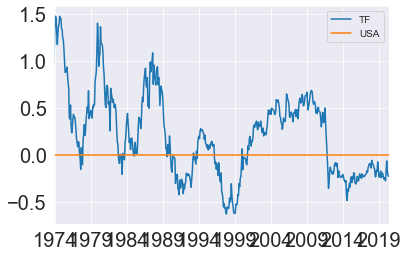

In [128]:
rolling_performance = (1.+result).rolling(window=36).agg(lambda x : x.prod()).dropna()

rolling_performance = rolling_performance.subtract(pd.Series(rolling_performance['USA']), axis = 0)

rolling_performance.plot()

# Test

In [49]:
def TrendFollowing_Backtest(data,benchmark, top_N = 3):
    if len(data.columns) < top_N:
        print('Decrese Top_N or Increse Assets')
    
    else:
        #Calculate Benchmark Return
    
        bench_ret = benchmark.shift(-1)/benchmark - 1
        bench_ret = bench_ret[13:]
        bench_ret = pd.DataFrame(bench_ret)
        
        #Create Momentum frames
        mom_df = data.copy()
        mom3_df=mom_df.apply(lambda x:x/x.shift(3) - 1, axis=0)
        mom6_df=mom_df.apply(lambda x:x/x.shift(6) - 1, axis=0)
        mom12_df=mom_df.apply(lambda x:x/x.shift(12) - 1, axis=0)

        comb_mom_df=mom12_df+mom6_df+mom3_df
    
    
        returns_df=data.copy()
        #shifting returns back to avoid bias
        returns_df=returns_df.apply(lambda x:x.shift(-1)/x - 1, axis=0)
    
        #ranking assets
        rank_df=comb_mom_df.rank(axis=1,ascending=False)
    
        #all top_N assets are choosen
        for col in rank_df.columns:
            rank_df[col]=np.where(rank_df[col]<=top_N, 1, 0)
    
        
        portf=np.multiply(rank_df,returns_df)
        portf_rets=portf.sum(axis =1)/top_N
    
        portf_rets = portf_rets[13:]
        portf_rets = pd.DataFrame(portf_rets)
        portf_rets.columns = ['TF']
    
        result = pd.concat([portf_rets, bench_ret], axis = 1)
        result = result.dropna()
    
    
    
        result = result+1
        result = result.cumprod()
        result = result.astype('float64')

    
        return(result)

In [50]:
#result = TrendFollowing_Backtest(data, data['USA'], top_N = 2)

In [51]:
#result

In [52]:
returns_df

,JAPAN,USA,SWEDEN,Emerging_Markets,PACIFIC_ex_JAPAN,USD (AM),Bond 5 Yr
1987-12-01,0.0539398,0.0428337,0.0985123,0.09838,-0.00966196,-0.043679,0.010722
1988-01-01,0.0756044,0.0418689,0.0381778,0.00339591,-0.00417911,-0.089199,0.029833
1988-02-01,0.0754391,-0.0334565,0.0707736,0.107385,0.121175,0.080826,0.011079
1988-03-01,0.0104825,0.00918364,0.0293066,0.0533815,0.0486934,-0.018013,-0.009579
1988-04-01,-0.0450937,0.00860268,0.027252,0.0299624,0.0709892,0.009450,-0.004891
...,...,...,...,...,...,...,...
2020-02-01,-0.0697983,-0.126836,-0.138188,-0.153771,-0.202395,-0.013343,0.021125
2020-03-01,0.0538817,0.131539,0.0821897,0.091768,0.117239,0.069859,0.027329
2020-04-01,0.0592286,0.0520172,0.0756264,0.00789326,-0.0039942,0.005184,0.001774
2020-05-01,9.40389e-05,0.0228186,0.0342441,0.0740262,0.080348,0.026106,0.002288


In [39]:
result

,TF,USA
1971-01-01,1.012004,1.010692
1971-02-01,1.044337,1.052264
1971-03-01,1.092302,1.093654
1971-04-01,1.067825,1.051672
1971-05-01,1.123224,1.059401
...,...,...
2020-01-01,764.272196,114.072253
2020-02-01,767.245948,99.603826
2020-03-01,804.529562,112.705629
2020-04-01,807.328660,118.568261
